Initial setup and first topic model run

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

In [3]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [4]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 15754
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [5]:
corpora_df = wosis.rc_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)
#maybe we don't want to do this for this analysis? older papers less likely to have dois?

Removing 1799 records with no DOIs


In [6]:
# removed_pubs

In [7]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,AU,SO,title,year
0,"Malone, R. W.|Kersebaum, K. C.|Kaspar, T. C.|M...",AGRICULTURAL WATER MANAGEMENT,Winter rye as a cover crop reduces nitrate los...,2017
1,"Ali, Mohamed E. M.|Gad-Allah, Tarek A.|Elmolla...",DESALINATION AND WATER TREATMENT,Heterogeneous Fenton process using iron-contai...,2014
3,"Nakao, Shunsuke",AEROSOL SCIENCE AND TECHNOLOGY,Why would apparent kappa linearly change with ...,2017
4,"Sharma, P.|Sarker, B. R.|Romagnoli, J. A.",COMPUTERS & CHEMICAL ENGINEERING,A decision support tool for strategic planning...,2011
5,"Lin, CH|Lin, YS",COMPUTERS & OPERATIONS RESEARCH,The production size and inventory policy for a...,2005


In [8]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

In [9]:
from wosis.analysis import find_topics

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_results = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [10]:
topic_pubs = {
    'model': topic_results.get_topic_by_id(4),
    # 'UA': topic_results.get_topic_by_id(8),
    # 'SA': topic_results.get_topic_by_id(20),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

3203

In [11]:
# find paper of interest - see if it's still in the corpora
for i in range(1,6):
    topic_set = topic_results.get_topic_by_id(i)
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = wosis.rc_to_df(topic_recs)
    
    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [12]:
topic_4_set = topic_results.get_topic_by_id(4)

In [13]:
topic_4_set.loc[:, ~topic_4_set.columns.isin(hide_columns)].head(10)

,AU,SO,title,year
6,"Smith, R. I.|Dick, J. McP.|Scott, E. M.",ENVIRONMETRICS,The role of statistics in the analysis of ecos...,2011
12,"Khatami, Reza|Mountrakis, Giorgos|Stehman, Ste...",REMOTE SENSING OF ENVIRONMENT,Mapping per-pixel predicted accuracy of classi...,2017
15,"Arias, Manuel|Angel Artaso, Miguel|Bermejo, In...","ARTIFICIAL INTELLIGENCE IN MEDICINE, AIME 2017",Advanced Algorithms for Medical Decision Analy...,2017
18,"Noori, Roohollah|Ashrafi, Khosro|Karbassi, Abd...",ENVIRONMENTAL PROGRESS & SUSTAINABLE ENERGY,Development and application of reduced-order n...,2013
20,"Knighton, James|Lennon, Edward|Bastidas, Luis|...",JOURNAL OF HYDROLOGIC ENGINEERING,Stormwater Detention System Parameter Sensitiv...,2016
40,"Boithias, Laurie|Terrado, Marta|Corominas, Llu...",SCIENCE OF THE TOTAL ENVIRONMENT,Analysis of the uncertainty in the monetary va...,2016
55,"Fernandez Martinez, Juan L.|Pedruelo Gonzalez,...",MATHEMATICAL GEOSCIENCES,Anisotropic Mean Traveltime Curves: A Method t...,2009
61,"Lee, Dooho|Kim, Nam H.|Kim, Hyeon-Seok",STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,Validation and updating in a large automotive ...,2016
69,"Russo, Serena|Luchini, Paolo",JOURNAL OF COMPUTATIONAL PHYSICS,A fast algorithm for the estimation of statist...,2017
70,"Dai, Zhuo|Zheng, Xiaoting",COMPUTERS & INDUSTRIAL ENGINEERING,Design of close-loop supply chain network unde...,2015


In [14]:
topic_4_recs = wosis.extract_recs(topic_4_set.loc[:, 'id'], RC, 'Topic of Interest')

In [15]:
#run topic model on topic 4
topic_4_subtopics = find_topics(topic_4_set, num_topics=5)

C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Topic 1: uncertainty model uncertainties analysis water data quality models assessment modeling
Topic 2: stochastic polynomial chaos random quantification equations method expansion collocation solution
Topic 3: sensitivity analysis model models global parameters indices input based output
Topic 4: bayesian model data parameter models calibration inference posterior prior estimation
Topic 5: carlo monte sampling method probability simulation failure distribution reliability function


<hr>

Plotting subtopic trends over time <br>
Two topics are chosen, papers focusing on applications of SA and papers focusing on theoretical development of SA <br>
The next task is to plot the category trends over time.

In [16]:
subtopic1 = topic_4_subtopics.get_topic_by_id(1)
subtopic3 = topic_4_subtopics.get_topic_by_id(3)
subtopic4 = topic_4_subtopics.get_topic_by_id(4)

In [17]:
uncertainty_model__applications = wosis.extract_recs(subtopic1['id'], RC, name='applications')

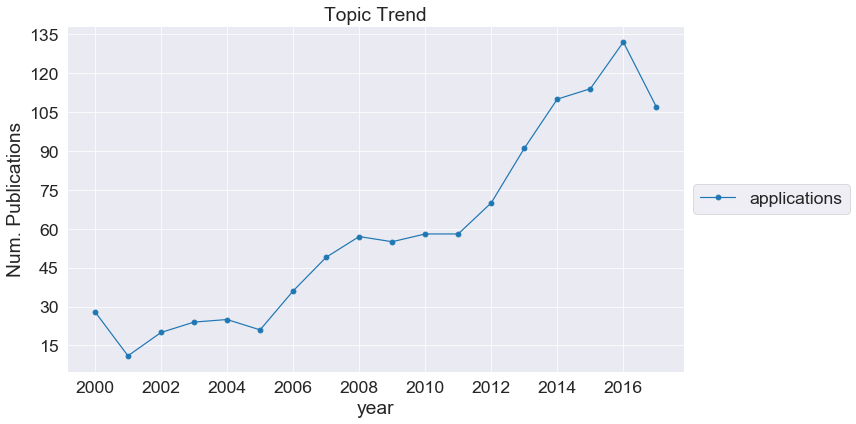

In [20]:
wos_plot.plot_topic_trend([uncertainty_model__applications, ], total_rc=None, title='Topic Trend')

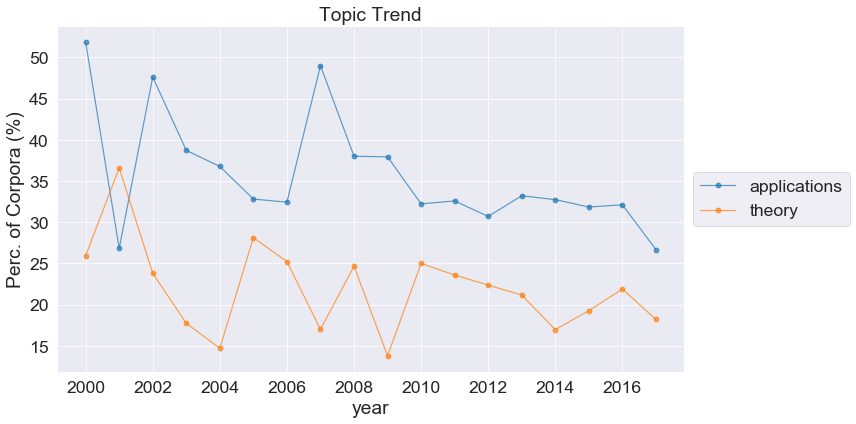

In [21]:
uncertainty_model__sa = wosis.extract_recs(subtopic3['id'], RC, name='theory')

wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=topic_recs, title='Topic Trend')

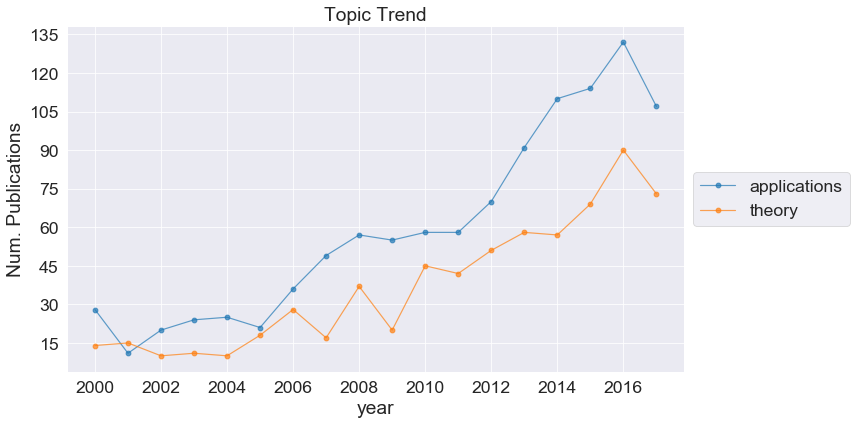

In [22]:
wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=None, title='Topic Trend')

<hr>

Here the results to app_paper are sorted with reference to the packages they support.
<br> Still to complete: plot each criterion's trend

In [23]:
#keyword criteria match on app_papers
#want to see trend of keywords over time
#add languages
uncertainty_topic_df = topic_results.get_topic_by_id(4)

uncertainty_models_rc = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')
# topic_4_1_recs = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')

criteria = {
    'GLUE': set(['GLUE', 'generalized likelihood uncertainty estimation', 'distributed models', 'calibration uncertainty', 'likelihood', 'uncertainty estimation', 'epistemic error', 'rainfall-runoff models', 'equifinality', 'Plynlimon']),
    'PEST': set(['PEST', 'parameter estimation', 'model-independent parameter estimation & uncertainty analysis', 'user interfaces', 'computer systems', 'data processing', 'least squares', 'spatial systems', 'mathematical models', 'software']),
    'SALib': set(['salib', 'sensitivity analysis', 'python', 'uncertainty', 'variance-based', 'global sensitivity analysis', 'fractional factorial', 'method of morris']),
    'MADS': set(['sensitivity analysis', 'MADS', 'julia', 'julialang', 'parameter estimation', 'model inversion & calibration', 'uncertainty quantification', 'model selection', 'model averaging', 'model reduction', 'surrogate modeling', 'machine learning', 'blind source separation', 'decision analysis & support']),
    'PSUADE': set(['uncertainty quantification', 'sensitivity analysis', 'parameter estimation', 'space-filling sample', 'PSUADE', 'Problem Solving environment for Uncertainty Analysis and Design Exploration']),
    'SAFE': set(['global sensitivity analysis', 'matlab', 'octave', 'open-source software', 'safe', 'sensitivity analysis for everyone']),
    'VARS-TOOL': set(['VARS-TOOL', 'VARS', 'global sensitivity analysis', 'uncertainty analysis', 'variogram analysis of response surfaces', 'variogram', 'sobol', 'morris', 'progressive latin hypercube sampling', 'plhs', 'dynamical systems models', 'sensitivty indices', 'performance metrics']),
    'UQLab': set(['uncertainty quantification', 'uncertainty analysis', 'sensitivity analysis', 'computer systems', 'uqlab']),
    'DAKOTA': set(['dakota', 'mathematical methods', 'computing', 'computer-aided design', 'finite element method', 'nonlinear programming', 'sensitivity analysis', 'parallel processing', 'stochastic processes', 'integer processing', 'iterative methods', 'computer programs']),
    'HDMR': set(['global sensitivity analysis', 'hdmr', 'high dimensional model representation', 'matlab', 'matlab software', 'graphic user interface', 'gui']),
    'SimLab': set(['sensitivity analysis', 'uncertainty analysis', 'model development', 'global sensitivity analysis', 'simlab'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_models_rc, criteria, threshold=95.0)

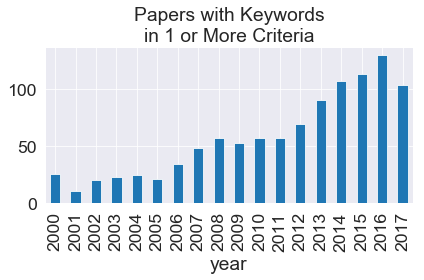

In [24]:
criteria1_df = wosis.collate_keyword_criteria_matches(uncertainty_models_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria1_df, threshold=1)

<hr>

The following includes more analysis of the papers from topic 4 and topic 4.3. <br>
- Publication trends
- Criteria matching and trends of criteria.

In [25]:
uncertainty_sa_df = topic_4_subtopics.get_topic_by_id(3)
uncertainty_sa_rc = wosis.extract_recs(uncertainty_sa_df.loc[:, 'id'], topic_recs, 'Topic of Interest')
# tmp_df = wosis.rc_to_df(uncertainty_sa_rc)

In [26]:
uncertainty_sa_df.loc[:, ~topic_set.columns.isin(hide_columns)].head()

,AU,SO,title,year
15,"Arias, Manuel|Angel Artaso, Miguel|Bermejo, In...","ARTIFICIAL INTELLIGENCE IN MEDICINE, AIME 2017",Advanced Algorithms for Medical Decision Analy...,2017
61,"Lee, Dooho|Kim, Nam H.|Kim, Hyeon-Seok",STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,Validation and updating in a large automotive ...,2016
87,"Amin, Saman Hassanzadeh|Baki, Fazle",APPLIED MATHEMATICAL MODELLING,A facility location model for global closed-lo...,2017
118,"Kioutsioukis, |Tarantola, S|Saltelli, A|Gatell...",ATMOSPHERIC ENVIRONMENT,Uncertainty and global sensitivity analysis of...,2004
139,"Plyasunov, Sergey|Arkin, Adam P.",JOURNAL OF COMPUTATIONAL PHYSICS,Efficient stochastic sensitivity analysis of d...,2007


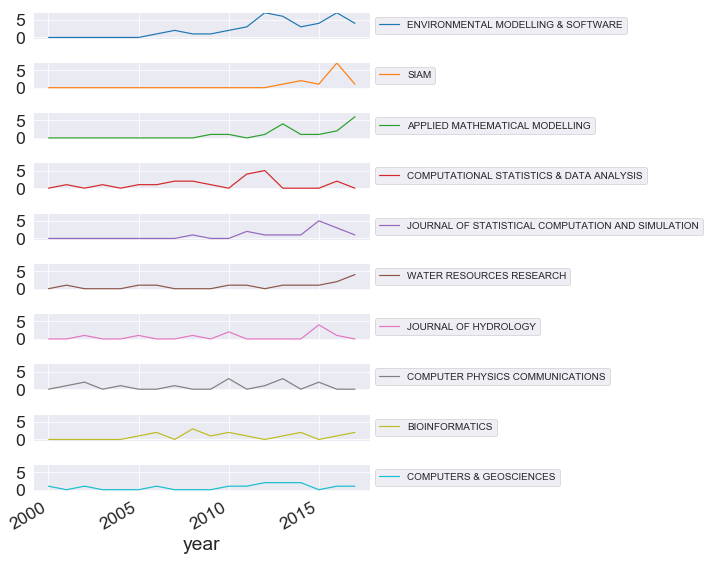

In [27]:
#publication trend for top 10 journals
wos_plot.plot_journal_pub_trend(uncertainty_sa_rc)

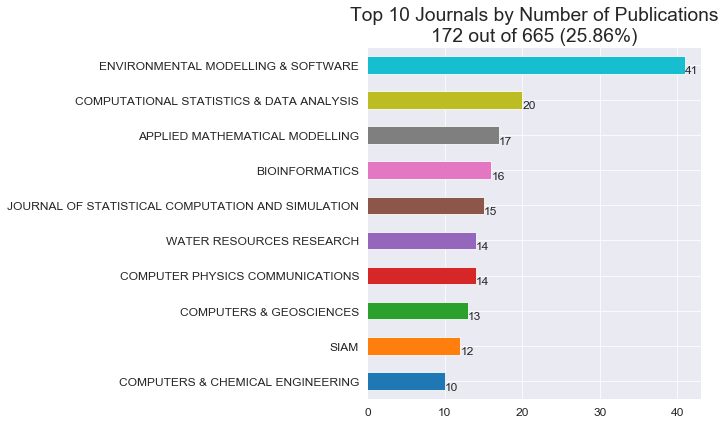

In [28]:
#Top 10 jorunals by number of publications
wos_plot.plot_pubs_per_journal(uncertainty_sa_rc, top_n=10, annotate=True, show_stats=True)

In [29]:
#top papers by cited papers within the corpora
wosis.analysis.pub_citations(uncertainty_sa_rc)[0:5]

#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Saltelli, A, 1999, A quantitative model-independent method for global sensitivity analysis of model output, TECHNOMETRICS, 41, 39, 6699137",328
"Saltelli, A., 2004, Sensitivity Analysis in Practice, A guide to Assesing Scientific Models, 287480276",183
"Sobol, I. M., 1993, Sensitivity analysis for nonlinear mathematical models, Math. Model. Comput. Exp., 1, 407, 2602363",160
"Sobol, IM, 2001, Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates, MATHEMATICS AND COMPUTERS IN SIMULATION, 55, 271, 1049401",111
"Saltelli, Andrea, 2010, Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index, COMPUTER PHYSICS COMMUNICATIONS, 181, 259, 287085385",99


In [30]:
# first 10 papers in chosen topic (unordered)
uncertainty_sa_doi = wosis.link_to_pub(uncertainty_sa_rc)  # Creates a new column called 'DOI link'
uncertainty_sa_doi.loc[:, ~uncertainty_sa_doi.columns.isin(hide_columns)].head(10)

,AU,SO,title,year,DOI link
0,"Huang, Ke|Liu, Yu|Korolija, Nenad|Carulli, Joh...",IEEE TRANSACTIONS ON COMPUTER-AIDED DESIGN OF ...,Recycled IC Detection Based on Statistical Met...,2015,https://dx.doi.org/10.1109/TCAD.2015.2409267
1,"Zhao, Yu|Li, Mingtao|Yuan, Sanling",INTERNATIONAL JOURNAL OF ENVIRONMENTAL RESEARC...,Analysis of Transmission and Control of Tuberc...,2017,https://dx.doi.org/10.3390/ijerph14101192
2,"Constantine, Paul G.|Zaharatos, Brian|Campanel...",STATISTICAL ANALYSIS AND DATA MINING,Discovering an active subspace in a single-dio...,2015,https://dx.doi.org/10.1002/sam.11281
3,"Xu, C.|Gertner, G.",COMPUTATIONAL STATISTICS & DATA ANALYSIS,Extending a global sensitivity analysis techni...,2007,https://dx.doi.org/10.1016/j.csda.2007.04.003
4,"Ben-Haim, Gev|Dalyot, Sagi|Doytsher, Yerach",2013 FOURTH INTERNATIONAL CONFERENCE ON COMPUT...,Geostatistical Approach for Computing Absolute...,2013,https://dx.doi.org/10.1109/COMGEO.2013.6
5,"Bashkirtseva, Irina",DISCRETE DYNAMICS IN NATURE AND SOCIETY,Preventing Noise-Induced Extinction in Discret...,2017,https://dx.doi.org/10.1155/2017/9610609
6,"Garg, Akhil|Vijayaraghavan, Venkatesh|Tai, Kan...",ENGINEERING COMPUTATIONS,An ensemble evolutionary approach in evaluatio...,2015,https://dx.doi.org/10.1108/EC-03-2014-0047
7,"Zhou, Changcong|Lu, Zhenzhou|Li, Luyi|Feng, Ju...",APPLIED MATHEMATICAL MODELLING,A new algorithm for variance based importance ...,2013,https://dx.doi.org/10.1016/j.apm.2012.03.017
8,"Yildirim, N",INTERNATIONAL JOURNAL OF QUANTUM CHEMISTRY,Use of symbolic and numeric computation techni...,2006,https://dx.doi.org/10.1002/qua.20750
9,"Mara, Thierry A.|Tarantola, Stefano|Annoni, Paola",ENVIRONMENTAL MODELLING & SOFTWARE,Non-parametric methods for global sensitivity ...,2015,https://dx.doi.org/10.1016/j.envsoft.2015.07.010


In [31]:
uncertainty_sa_doi.to_csv('topic_4_3.csv')

In [32]:
# want to see trend of global SA over years
# also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_sa_rc, criteria, threshold=95.0)

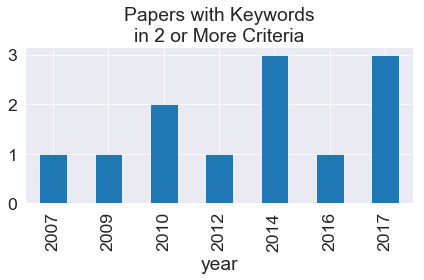

In [33]:
criteria_df = wosis.collate_keyword_criteria_matches(uncertainty_sa_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [34]:
# want to view the papers in the above plot
# crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
# crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

criteria_df.loc[criteria_df['num_criteria_match'] >= 2].sort_values('year').head()

,abstract,id,keywords,title,year,num_criteria_match
457,two different methods for global sensitivity a...,WOS:000253383200010,COUPLED REACTION SYSTEMS|RATE COEFFICIENTS|UNC...,Comparing global sensitivity analysis for a bi...,2007,2
487,global sensitivity analysis techniques are bet...,WOS:000269457200019,RADIOACTIVE-WASTE DISPOSAL|PERFORMANCE ASSESSM...,Global Sensitivity Analysis Techniques for Pro...,2009,2
479,senssb sensitivity analysis for systems biolog...,WOS:000278967500018,,SensSB: a software toolbox for the development...,2010,2
520,this paper presents an efficient samplingbased...,WOS:000284184800017,INDEXES,Global sensitivity of structural variability b...,2010,2
85,when investigating modeling or operating uncer...,WOS:000300862200002,GENERALIZED POLYNOMIAL CHAOS|UNCERTAINTY ANALY...,Global sensitivity analysis: A flexible and ef...,2012,2


In [35]:
lsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['local sensitivity', 'LSA', 'local sensitivity analysis'], threshold=95.0)

In [36]:
gsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['global sensitivity', 'GSA', 'global sensitivity analysis'], threshold=95.0)

In [37]:
oat_matches = wosis.keyword_matches(uncertainty_sa_rc, ['one-at-a-time', 'OAT'], threshold=95.0)

In [38]:
lsa_matches

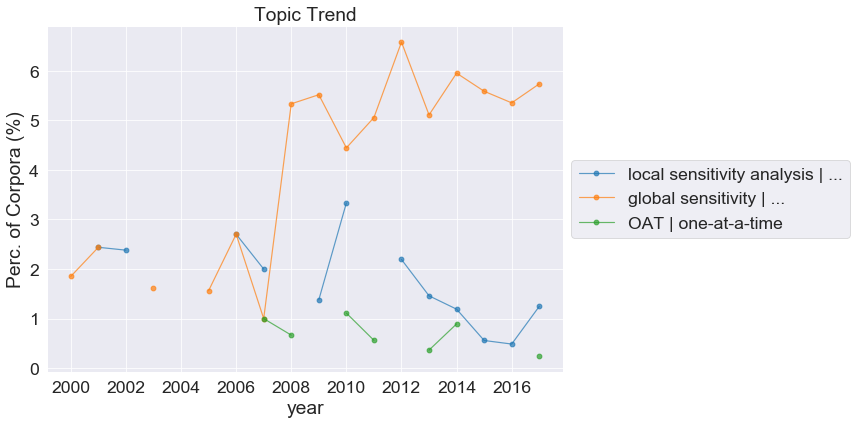

In [39]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches], 
                          topic_4_recs)

<hr>

Network analysis, cocite and coauthor networks
<br> Further formatting/data extraction required, see networkx documentation

In [40]:
# import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# co-author network
coAuths = topic_recs.networkCoAuthor()
print(mk.graphStats(coAuths))

Nodes: 8721
Edges: 21454
Isolates: 148
Self loops: 2
Density: 0.000564229
Transitivity: 0.841433


C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))
C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


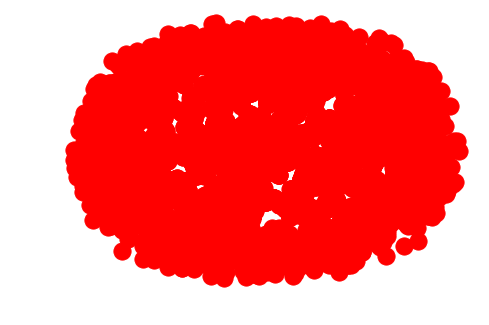

In [42]:
nx.draw_spring(coAuths, with_labels=False)

In [43]:
# highly cited co-atuhor network, how do I limit nodes? Needs to use topic 1 only, not full data base
minWeight = 3
maxWeight = 10
proccessedcoAuths = coAuths.copy()
mk.dropEdges(proccessedcoAuths, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths)

'Nodes: 8721\nEdges: 271\nIsolates: 8427\nSelf loops: 0\nDensity: 7.12716E-06\nTransitivity: 0.754757'

In [44]:
mk.dropNodesByDegree(proccessedcoAuths, 1)
mk.graphStats(proccessedcoAuths)

'Nodes: 294\nEdges: 271\nIsolates: 0\nSelf loops: 0\nDensity: 0.00629194\nTransitivity: 0.754757'

C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


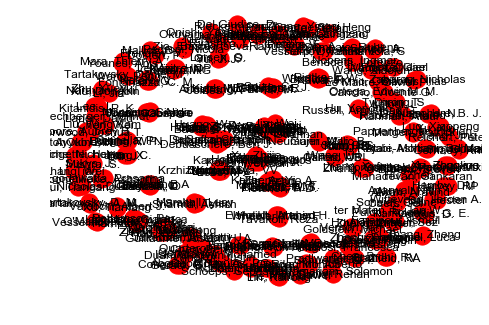

In [45]:
nx.draw_spring(proccessedcoAuths, with_labels=True)

In [46]:
minWeight = 30
maxWeight = 35
coCites = uncertainty_sa_rc.networkCoCitation()
mk.dropEdges(coCites, minWeight, maxWeight, dropSelfLoops=True)
mk.dropNodesByDegree(coCites, 5)
print(mk.graphStats(coCites))

Nodes: 49
Edges: 51
Isolates: 0
Self loops: 0
Density: 0.0433673
Transitivity: 0.0372671


C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


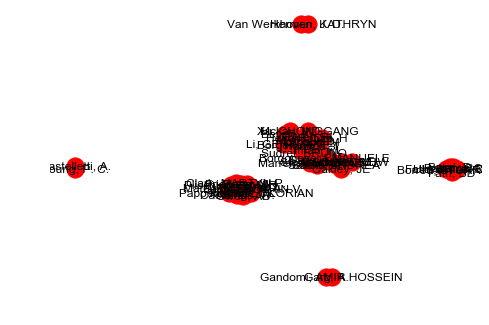

In [47]:
nx.draw_spring(coCites, with_labels=True)